In [1]:
import torch
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random

In [2]:
#Architecture parameters and distributions of stimuli
N = 10
K = 10
p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 5000
N_SAMPLES = 500
lr = 1e-2
BATCH_SIZE = 500
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]  #creates a 1D tensor of size 1000 whose values are evenly spaced from x_min and x_max



In [3]:
#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2,x_sorted)
inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)  #(-mu/(sigma)^2 , -1/2*(sigma^2))
dec = GaussianDecoder(phi0)
dec_perc = MLPDecoder(N,200)


Text(0, 0.5, 'Encoding')

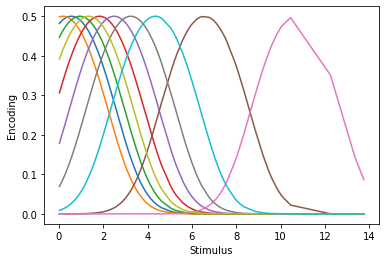

In [5]:
#Initialized encoder before training
plt.plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [6]:
#create the matrix of the total possible vectors of r (possible patterns) for N=10 neurons
N = 10
r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
r1.shape
r = torch.tensor(r1).transpose(0,1)
r.shape

torch.Size([10, 1024])

In [4]:
#Definition of the rate function for the Ising prior

def rate_ising3(x,encoder,h,J):
    eta = encoder(x)
    r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
    r = torch.tensor(r1).transpose(0,1).type(torch.float)
    p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    log_ratio = ((eta-h0)@r - (r*(J0@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
    logz = torch.log((torch.exp((h0@r) + (r*(J0@r)).sum(dim=0, keepdim=True))).sum(dim=1))

    return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

In [9]:
#Training: loss = distortion + rate
lossVec = []
rateVec = []
distVec = []
J0 = torch.eye(10).type(torch.float)
h0 = torch.zeros((1,10)).type(torch.float)
params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec) + rate_ising3(x_,enc, h0, J0)
        #print(loss)
        rate = rate_ising3(x_,enc,h0,J0)
        dist = distortion_gaussian(x_,enc,dec)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Text(0, 0.5, 'Loss')

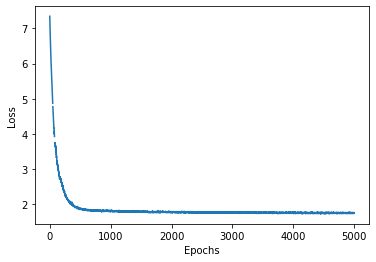

In [10]:
plt.plot(lossVec)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Rate')

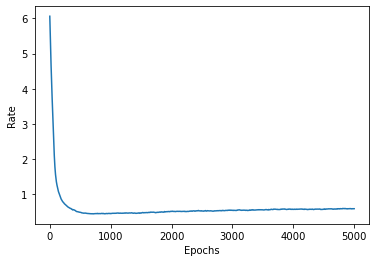

In [11]:
plt.plot(rateVec)
plt.xlabel("Epochs")
plt.ylabel("Rate")

Text(0, 0.5, 'Distortion')

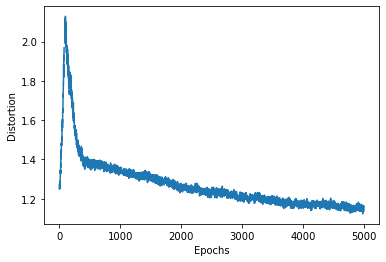

In [12]:
plt.plot(distVec)
plt.xlabel("Epochs")
plt.ylabel("Distortion")

Text(0, 0.5, 'Encoding')

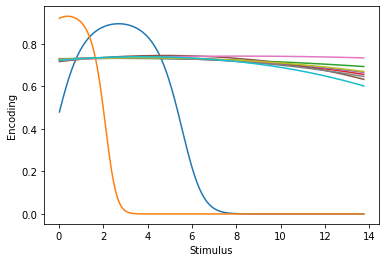

In [13]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

Text(0, 0.5, 'MSE')

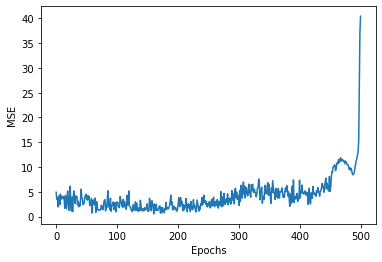

In [14]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec)
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [15]:
#Training: loss = distortion
lossVec = []
rateVec = []
distVec = []
J0 = torch.eye(10).type(torch.float)
h0 = torch.zeros((1,10)).type(torch.float)
params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec)
        #print(loss)
        rate = rate_ising3(x_,enc,h0,J0)
        dist = distortion_gaussian(x_,enc,dec)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Text(0, 0.5, 'Loss')

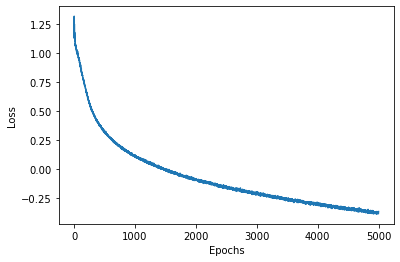

In [16]:
plt.plot(lossVec)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Rate')

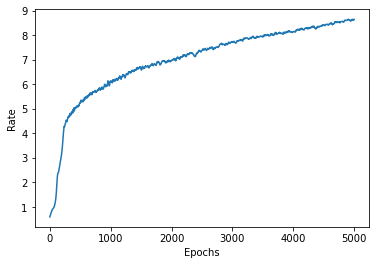

In [17]:
plt.plot(rateVec)
plt.xlabel("Epochs")
plt.ylabel("Rate")

Text(0, 0.5, 'Distortion')

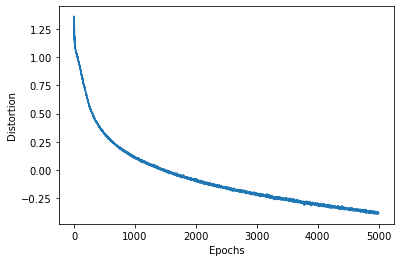

In [18]:
plt.plot(distVec)
plt.xlabel("Epochs")
plt.ylabel("Distortion")

Text(0, 0.5, 'MSE')

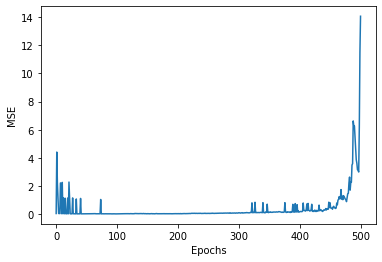

In [19]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec)
plt.xlabel("Epochs")
plt.ylabel("MSE")

Text(0, 0.5, 'Encoding')

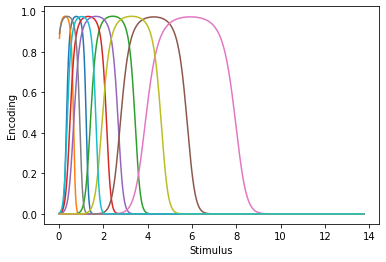

In [20]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

In [5]:
#Training using the multilayer perceptron as a decoder (TO DO)
dec_perc = MLPDecoder(N,200)

lossVec = []
rateVec = []
distVec = []
J0 = torch.eye(10).type(torch.float)
h0 = torch.zeros((1,10)).type(torch.float)
params = list(enc.parameters()) + list(dec_perc.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec) + rate_ising3(x_, enc, h0, J0)
        #print(loss)
        rate = rate_ising3(x_,enc,h0,J0)
        dist = distortion_gaussian(x_,enc,dec)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Text(0, 0.5, 'Loss')

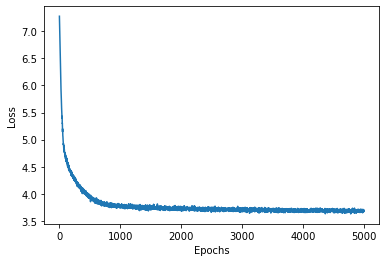

In [6]:
plt.plot(lossVec)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Rate')

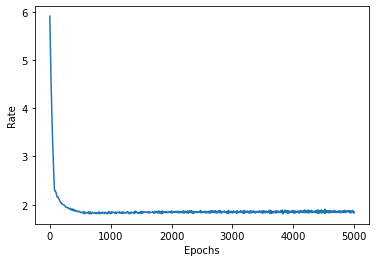

In [7]:
plt.plot(rateVec)
plt.xlabel("Epochs")
plt.ylabel("Rate")

Text(0, 0.5, 'Distortion')

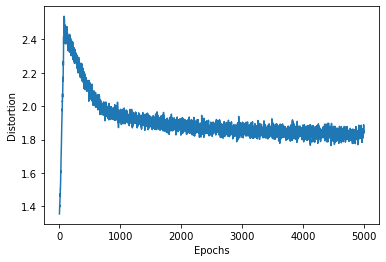

In [8]:
plt.plot(distVec)
plt.xlabel("Epochs")
plt.ylabel("Distortion")

Text(0, 0.5, 'MSE')

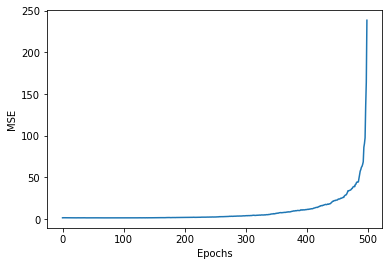

In [9]:
r = enc.sample(x_sorted,100)
x_dec = dec_perc.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec)
plt.xlabel("Epochs")
plt.ylabel("MSE")

POSSIBLE INITIALIZATION OF JO

In [24]:
#J0 initialized as the inverse of the r's correlation matrix

r = enc.sample(x_sorted,100)
b = r.sum(dim=0)    #pensarci ancora un attimo dim=0 o dim=1???
corr = b.transpose(0,1)@b
corr.shape
J0_in_arr = np.linalg.inv(corr)
J0_in = torch.tensor(J0_in_arr)
b.shape
J0_in.shape


torch.Size([10, 10])

In [25]:
lossVec = []
rateVec = []
distVec = []
J0 = J0_in
h0 = torch.zeros((1,10)).type(torch.float)
params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec) + rate_ising3(x_,enc, h0, J0)
        #print(loss)
        rate = rate_ising3(x_,enc,h0,J0)
        dist = distortion_gaussian(x_,enc,dec)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Text(0, 0.5, 'Loss')

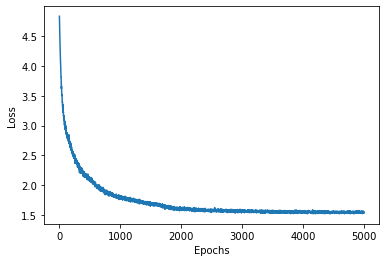

In [26]:
plt.plot(lossVec)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Rate')

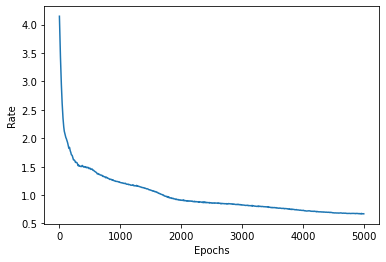

In [27]:
plt.plot(rateVec)
plt.xlabel("Epochs")
plt.ylabel("Rate")


Text(0, 0.5, 'Distortion')

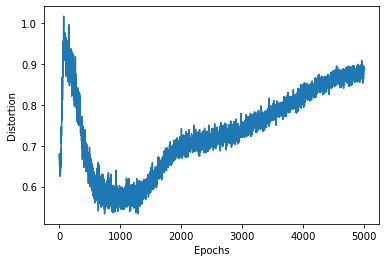

In [28]:
plt.plot(distVec)
plt.xlabel("Epochs")
plt.ylabel("Distortion")

Text(0, 0.5, 'Encoding')

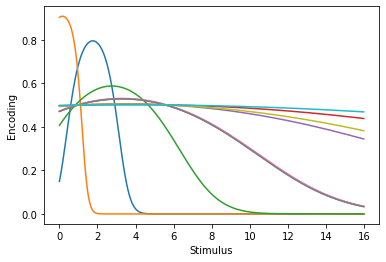

In [29]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
plt.xlabel("Stimulus")
plt.ylabel("Encoding")

Text(0, 0.5, 'MSE')

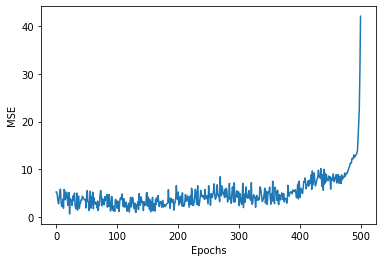

In [72]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec)
plt.xlabel("Epochs")
plt.ylabel("MSE")

LEARNING OF h AND J

In [10]:
#rate function Ising prior

#h and J learned


class rate_ISING(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        h0 = torch.zeros((1,10)).type(torch.float)
        J0 = torch.eye(10).type(torch.float)
        self.h = torch.nn.Parameter(h0)
        self.J = torch.nn.Parameter(J0)
    def forward(self,x):
        eta = enc(x) #problema
        r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
        r = torch.tensor(r1).transpose(0,1).type(torch.float)
        p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
        log_ratio = ((eta-self.h)@r - (r*(self.J@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
        logz = torch.log((torch.exp((self.h@r) + (r*(self.J@r)).sum(dim=0, keepdim=True))).sum(dim=1))
        
        return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz


def rate_ising_learn(x,encoder,h,J):
    eta = encoder(x)
    r1 = np.asarray(list(itertools.product([0, 1], repeat=N)))
    r = torch.tensor(r1).transpose(0,1).type(torch.float)
    p_r_x = torch.exp(eta@r - (torch.log( 1 + torch.exp(eta))).sum(dim=1)[:,None])
    log_ratio = ((eta-h0)@r - (r*(J0@r)).sum(dim=0, keepdim=True) - (torch.log(1+torch.exp(eta))).sum(dim=1)[:,None])
    logz = torch.log((torch.exp((h0@r) + (r*(J0@r)).sum(dim=0, keepdim=True))).sum(dim=1))

    return ((p_r_x)*(log_ratio)).sum(dim=1).mean() + logz

In [13]:
#Training
lossVec = []
rateVec = []
distVec = []
rate_i = rate_ISING()
params = list(enc.parameters()) + list(dec.parameters()) + list(rate_i.parameters())
optimizer = torch.optim.Adam(params,lr)
for epoch in range(N_EPOCHS):
    for x_ in x_data:
        loss = distortion_gaussian(x_,enc,dec) + rate_i(x_)
        #print(loss)
        rate = rate_i(x_)
        dist = distortion_gaussian(x_,enc,dec)
        lossVec.append(loss.item())
        rateVec.append(rate.item())
        distVec.append(dist.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Text(0, 0.5, 'Loss')

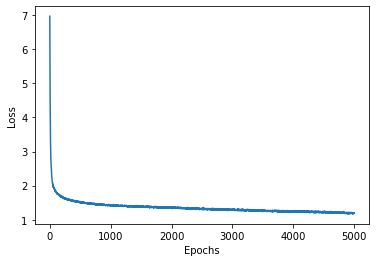

In [14]:
plt.plot(lossVec)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Rate')

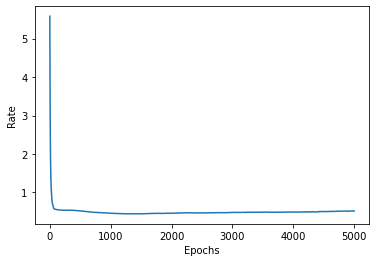

In [15]:
plt.plot(rateVec)
plt.xlabel("Epochs")
plt.ylabel("Rate")

Text(0, 0.5, 'Distortion')

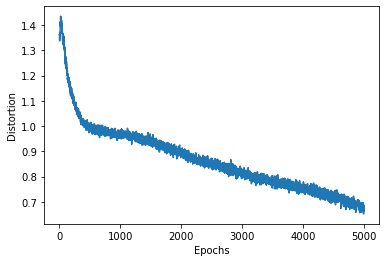

In [16]:
plt.plot(distVec)
plt.xlabel("Epochs")
plt.ylabel("Distortion")

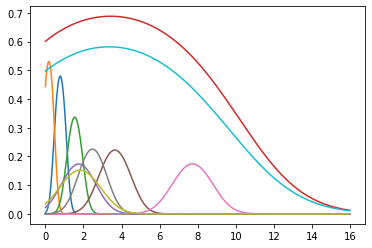

In [17]:
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach())

Text(0, 0.5, 'MSE')

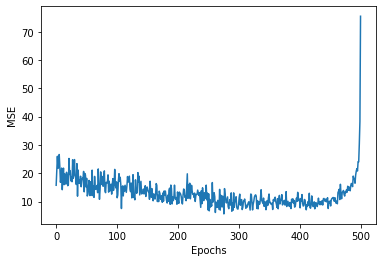

In [18]:
r = enc.sample(x_sorted,100)
x_dec = dec.sample(r,100)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec)
plt.xlabel("Epochs")
plt.ylabel("MSE")